Project using [abalone dataset](https://archive.ics.uci.edu/ml/datasets/Abalone) creating linear models. You can check this site to better understand the columns of the following dataframe.

In [ ]:
# Importamos las librerias necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.linalg as la
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold
from statsmodels.stats.stattools import durbin_watson

In [ ]:
df_aba = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data',header=None);
df_aba.columns = [f'x{i}' for i in range(0,9)];

In [ ]:
df_aba.head(3)

,x0,x1,x2,x3,x4,x5,x6,x7,x8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9


As stated in the UCI page the variable $x_8$ is an integer wich counts the number of rings and can be write as years by adding 1.5, this helps because make this discrete variable countinuous.

In [ ]:
df_aba.x8=df_aba.x8+1.5
df_aba.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5




---



First we wiil build a linear model of the form:
$$
y = \beta_0 + \sum_{i=1}^8 \beta_i \cdot x_i + \epsilon\,, \text{where, } \mathcal{N}(0,\, \sigma^2)\,,
$$
considering:

1.   show a two dimensional projection of the probability distribution of parameters using cross-validation.
2.   by using cross-validation, show a two dimensional projection of the probability distribution of errors. 
3.   accuracy of this model in average

### **Dataframe Exploration**

In [ ]:
# Se verifica la información del dataframe para comprobar los tipos de datos de las columnas
# y ver cuáles son nulas
df_aba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x0      4177 non-null   object 
 1   x1      4177 non-null   float64
 2   x2      4177 non-null   float64
 3   x3      4177 non-null   float64
 4   x4      4177 non-null   float64
 5   x5      4177 non-null   float64
 6   x6      4177 non-null   float64
 7   x7      4177 non-null   float64
 8   x8      4177 non-null   float64
dtypes: float64(8), object(1)
memory usage: 293.8+ KB


In [ ]:
# x0 es la única variable sin numeros, por lo que buscamos sus valores únicos
# para comprobar si se trata de una variable categorica
df_aba.x0.unique()

array(['M', 'F', 'I'], dtype=object)

In [ ]:
# Como se obtienen 3 valores, reemplazamos cada categoría por un número
df_aba['x0'] = df_aba['x0'].map({'M': 0, 'F': 1, 'I': 2})

# Se divide el dataframe entre el valor a predecir y las variables restantes
x = df_aba.iloc[:, :-1].values
y = df_aba.iloc[:,-1].values

### **Model Creation**

In [ ]:
# Se crea la función del modelo para calcular los coeficientes de la regresión lineal
def regression_model(x, y):
  # Se agrega una columna de unos a X para el término del intercepto
  x = np.hstack([np.ones((x.shape[0], 1)), x])

  theta = (la.inv(x.T @ x)) @ x.T @ y
  return theta

# Los coeficientes en general para el dataframe, el primero es el intercepto
beta = regression_model(x, y)
print(beta)

[  5.25926437  -0.3884832   -0.82639908  11.96403178  11.20449196
   9.07020864 -20.10614364 -10.15510106   8.70110596]


### **Cross Validation**

In [ ]:
# Creamos la función para realizar la validación cruzada
def cross_validation(regression_model, x, y):
  # Se define el número de chunks
  n_splits = 10

  # Se define el número de iterations
  iterations = 1000

  # Se definen las métricas
  coefficients = []
  r2_scores = []
  errors = []
  variances = []

  for i in range(iterations):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=i)

    # Se itera a través de los pliegues
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        theta = regression_model(x_train, y_train)
        x_test = np.hstack([np.ones((x_test.shape[0], 1)), x_test])
        y_pred = x_test @ theta
        error = y_test - y_pred

        coefficients.append(theta)
        errors.append(error)
        r2_scores.append(r2_score(y_test, y_pred))

  max_length = max(len(e) for e in errors)
  errors_estandarizados = np.array([np.pad(e, (0, max_length - len(e)), 'constant') for e in errors])
  return coefficients, errors_estandarizados, np.mean(r2_scores)

# Se guardan las variables necesarias para analizar el modelo
coefficients, errors, r2_scores = cross_validation(regression_model, x, y)

<Figure size 1000x800 with 0 Axes>

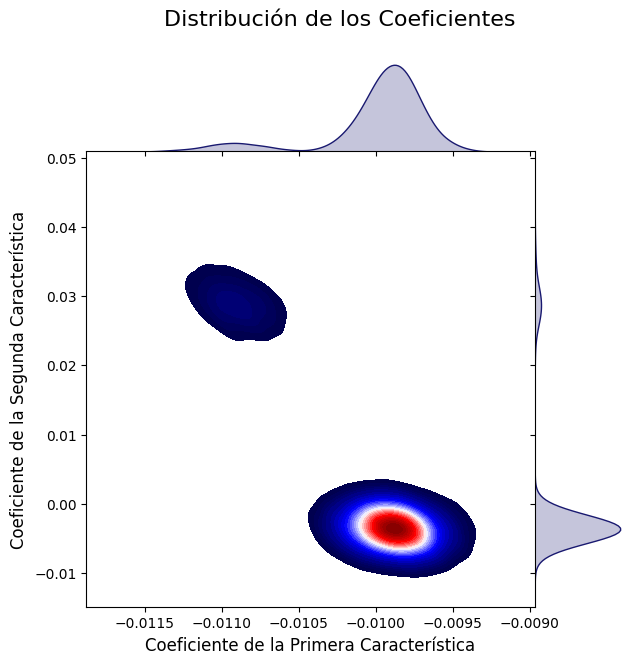

In [ ]:
# Se aplica SVD
U, S, Vt = np.linalg.svd(coefficients, full_matrices=False)

# Se seleccionan las componentes a graficar
x_axis = U[:, 0]
y_axis = U[:, 1]

# Se grafica la figura
plt.figure(figsize=(10, 8))
sns.jointplot(x=x_axis, y=y_axis, fill=True, kind="kde", space=0, color="midnightblue", n_levels=30, cmap="seismic")
plt.xlabel("Coeficiente de la Primera Característica", fontsize=12)
plt.ylabel("Coeficiente de la Segunda Característica", fontsize=12)
plt.suptitle("Distribución de los Coeficientes", fontsize=16, y=1.06)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'kind', 'space'
  cset = contour_func(


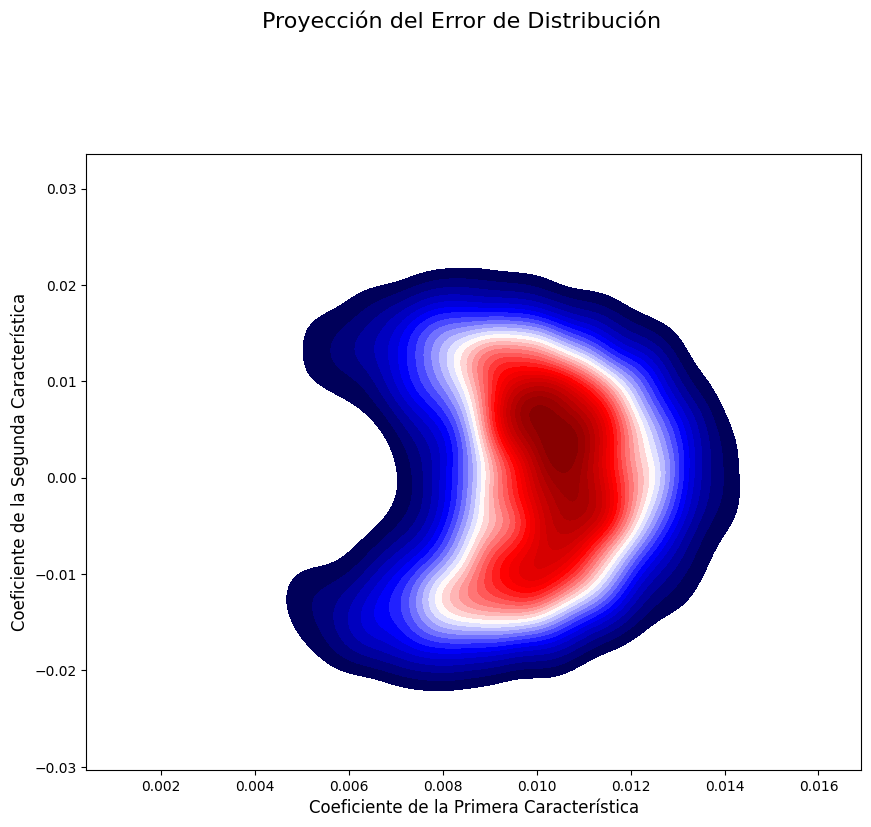

In [ ]:
# Se aplica SVD
U, S, Vt = np.linalg.svd(errors, full_matrices=False)

# Se seleccionan las componentes a graficar
x_axis = U[:, 0]
y_axis = U[:, 1]

# Se grafica la figura
plt.figure(figsize=(10, 8))
sns.kdeplot(x=x_axis, y=y_axis, fill=True, kind="kde", space=0, color="midnightblue", n_levels=30, cmap="seismic")
plt.xlabel("Coeficiente de la Primera Característica", fontsize=12)
plt.ylabel("Coeficiente de la Segunda Característica", fontsize=12)
plt.suptitle("Proyección del Error de Distribución", fontsize=16, y=1.06)
plt.show()

In [ ]:
errors = np.concatenate(errors)
dw_value = durbin_watson(errors)
print(f"Durbin-Watson: {dw_value}")

if dw_value < 1.5:
    print("Los errores poseen una correlación positiva")
elif 1.5 <= dw_value <= 2.5:
    print("Los errores no presentan una correlación definida")
else:
    print("Los errores poseen una correlación negativa")

Durbin-Watson: 1.5383623283976746
Los errores no presentan una correlación definida


In [ ]:
# Se calcula el error absoluto medio (MAE) para el modelo corregido
mae = np.mean(np.abs(errors))

# Se estima el valor sigma (desviación estándar de los errores) usando la corrección de Bessel
sigma = np.std(errors, ddof=1)

print(f"R²: {r2_scores}")
print(f"Error absoluto medio: {mae}")
print(f"Desviación estándar de los errores: {sigma}")

R²: 0.5224241531175955
Error absoluto medio: 1.5901811384098692
Desviación estándar de los errores: 2.222188333759117


---

Now we will build a linear model of the form:
$$
y = \beta_0 + \sum_{i=1}^8 \beta_i \cdot x_i  + \sum_{i=1}^{n-1} x_i \cdot x_{i+1} \cdot \beta_{8+i}\,, \text{where, } \sigma \sim \mathcal{N}(0,\, \sigma^2) \,,
$$
considering:

1.   show a two dimensional projection of the probability distribution of parameters using cross-validation.
2.   by using cross-validation, show a two dimensional projection of the probability distribution of errors. 
3.   accuracy of this model in average

In [ ]:
# Se crean los términos de interacción entre cada par de características consecutivas
df_encoded = df_aba.copy()
for i in range(0, 7):
    iteracion = df_encoded[f'x{i}'] * df_encoded[f'x{i+1}']
    df_encoded[f'interaction_{i}_{i+1}'] = iteracion

# Se muestran las primeras filas del conjunto de datos modificado con los términos de interacción
df_encoded.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,interaction_0_1,interaction_1_2,interaction_2_3,interaction_3_4,interaction_4_5,interaction_5_6,interaction_6_7
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5,0.00,0.166075,0.034675,0.048830,0.115393,0.022675,0.015150
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5,0.00,0.092750,0.023850,0.020295,0.022437,0.004826,0.003395
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5,0.53,0.222600,0.056700,0.091395,0.173651,0.036295,0.029715
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5,0.00,0.160600,0.045625,0.064500,0.111198,0.024567,0.017670
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5,0.66,0.084150,0.020400,0.016400,0.018347,0.003535,0.002172


In [ ]:
# Se preparan los datos para la regresión con los términos de interacción
x_interaction = df_encoded.drop('x8', axis=1).values
y_interaction = df_encoded['x8'].values

# Se realiza la validación cruzada
coefficients_interaction, errors_interaction, r2_scores = cross_validation(regression_model, x_interaction, y_interaction)
beta = regression_model(x, y_interaction)
print(beta)

[  5.25926437  -0.3884832   -0.82639908  11.96403178  11.20449196
   9.07020864 -20.10614364 -10.15510106   8.70110596]


<Figure size 1000x800 with 0 Axes>

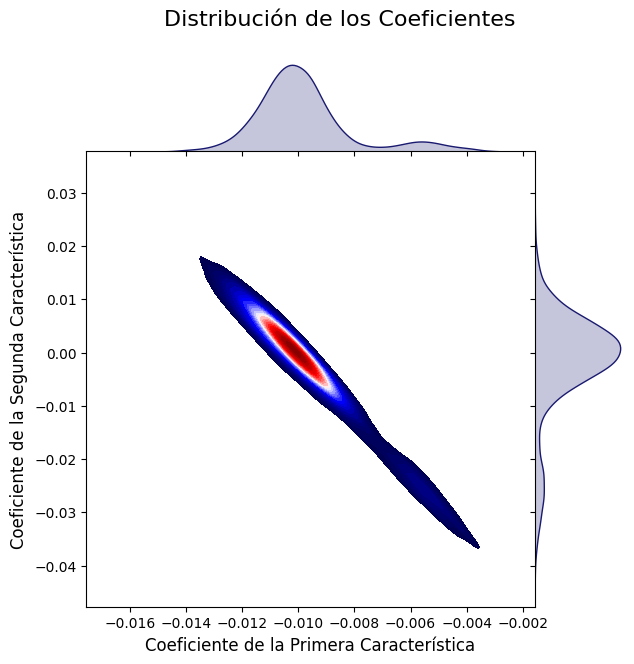

In [ ]:
# Se aplica SVD
U, S, Vt = np.linalg.svd(coefficients_interaction, full_matrices=False)

# Se seleccionan las componentes a graficar
x_axis = U[:, 0]
y_axis = U[:, 1]

# Se grafica la figura
plt.figure(figsize=(10, 8))
sns.jointplot(x=x_axis, y=y_axis, fill=True, kind="kde", space=0, color="midnightblue", n_levels=30, cmap="seismic")
plt.xlabel("Coeficiente de la Primera Característica", fontsize=12)
plt.ylabel("Coeficiente de la Segunda Característica", fontsize=12)
plt.suptitle("Distribución de los Coeficientes", fontsize=16, y=1.06)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'kind', 'space'
  cset = contour_func(


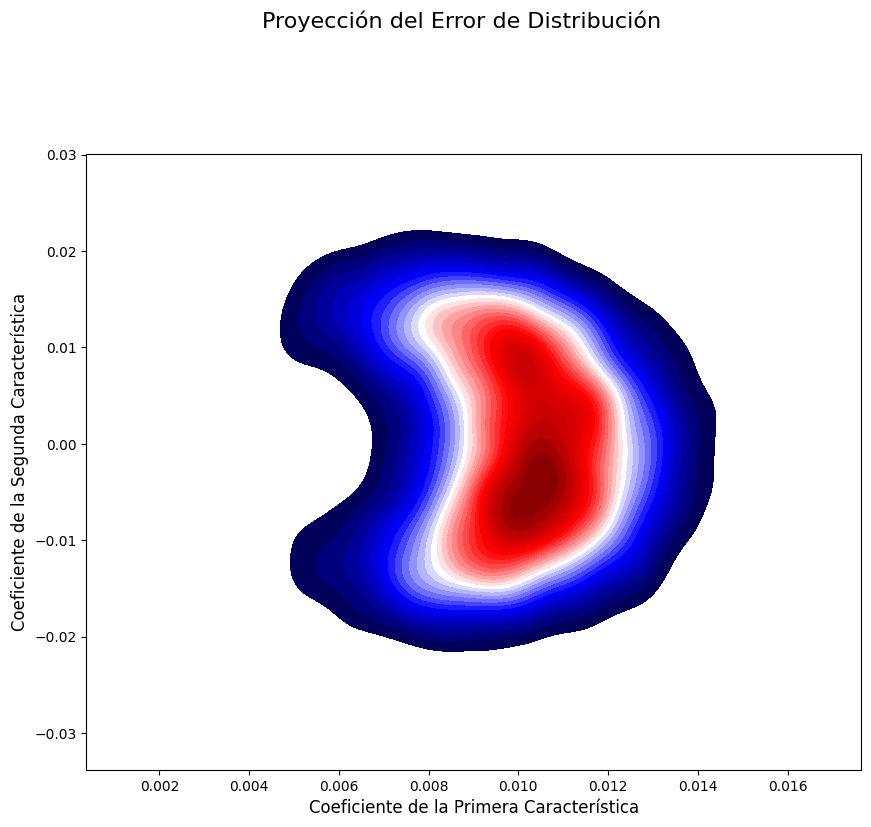

In [ ]:
# Se aplica SVD
U, S, Vt = np.linalg.svd(errors_interaction, full_matrices=False)

# Se seleccionan las componentes a graficar
x_axis = U[:, 0]
y_axis = U[:, 1]

# Se grafica la figura
plt.figure(figsize=(10, 8))
sns.kdeplot(x=x_axis, y=y_axis, fill=True, kind="kde", space=0, color="midnightblue", n_levels=30, cmap="seismic")
plt.xlabel("Coeficiente de la Primera Característica", fontsize=12)
plt.ylabel("Coeficiente de la Segunda Característica", fontsize=12)
plt.suptitle("Proyección del Error de Distribución", fontsize=16, y=1.06)
plt.show()

In [ ]:
errors_interaction = np.concatenate(errors_interaction)
dw_value = durbin_watson(errors_interaction)
print(f"Durbin-Watson: {dw_value}")

if dw_value < 1.5:
    print("Los errores poseen una correlación positiva")
elif 1.5 <= dw_value <= 2.5:
    print("Los errores no presentan una correlación definida")
else:
    print("Los errores poseen una correlación negativa")

Durbin-Watson: 1.5669271234843896
Los errores no presentan una correlación definida


In [ ]:
# Se calcula el error absoluto medio (MAE) para el modelo corregido
mae = np.mean(np.abs(errors))

# Se estima el valor sigma (desviación estándar de los errores) usando la corrección de Bessel
sigma = np.std(errors, ddof=1)

print(f"R²: {r2_scores}")
print(f"Error absoluto medio: {mae}")
print(f"Desviación estándar de los errores: {sigma}")

R²: 0.5491745048392798
Error absoluto medio: 1.5901811384098692
Desviación estándar de los errores: 2.222188333759117




---



Now we will build a linear model of the form:
$$
y = \beta_0 + \sum_{i=1}^8 \beta_i \cdot x_i  + \sum_{i=1}^{n} x_i^2 \cdot \beta_{8+i}\,, \text{where, } \sigma \sim \mathcal{N}(0,\, \sigma^2) \,,
$$
considering:

1.   show a two dimensional projection of the probability distribution of parameters using cross-validation.
2.   by using cross-validation, show a two dimensional projection of the probability distribution of errors. 
3.   accuracy of this model in average.

In [ ]:
df = df_aba.copy()
# Se crean términos cuadrados para cada característica
for i in range(0, 8):
    squared_term = df[f'x{i}'] ** 2
    df[f'squared_{i}'] = squared_term

# Se muestran las primeras filas del conjunto de datos modificado con términos cuadrados
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,squared_0,squared_1,squared_2,squared_3,squared_4,squared_5,squared_6,squared_7
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5,0,0.207025,0.133225,0.009025,0.264196,0.050400,0.010201,0.022500
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5,0,0.122500,0.070225,0.008100,0.050850,0.009900,0.002352,0.004900
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5,1,0.280900,0.176400,0.018225,0.458329,0.065792,0.020022,0.044100
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5,0,0.193600,0.133225,0.015625,0.266256,0.046440,0.012996,0.024025
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5,4,0.108900,0.065025,0.006400,0.042025,0.008010,0.001560,0.003025


In [ ]:
# Se preparan los datos para la regresión con términos cuadrados
x_squared = df.drop('x8', axis=1).values
y_squared = df['x8'].values

# Se realiza la validación cruzada para el modelo de términos cuadrados
coefficients_squared, errors_squared, r2_scores = cross_validation(regression_model, x_squared, y_squared)

beta = regression_model(x_squared, y_squared)
print(beta)

[  2.10230873   0.29013475  11.32620159  14.63814325  16.0107959
  20.6699138  -36.78994436 -20.34570731  12.3879065   -0.30426437
 -17.43831329 -12.03329827 -12.77902452  -4.03415973  15.50194974
  18.75805197  -2.92041954]


<Figure size 1000x800 with 0 Axes>

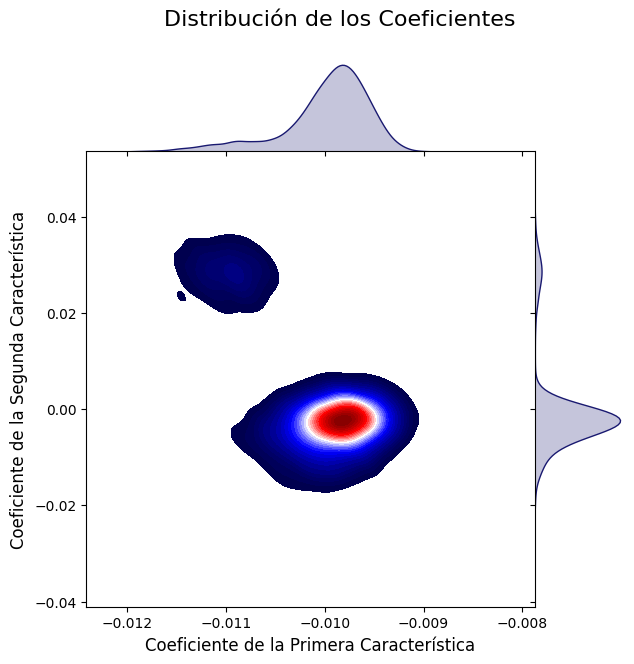

In [ ]:
# Aplicando SVD
U, S, Vt = np.linalg.svd(coefficients_squared, full_matrices=False)

# Selecciona diferentes componentes para graficar (p.ej., el tercero y el cuarto)
x_axis = U[:, 0]
y_axis = U[:, 1]

plt.figure(figsize=(10, 8))
sns.jointplot(x=x_axis, y=y_axis, fill=True, kind="kde", space=0, color="midnightblue", n_levels=30, cmap="seismic")
plt.xlabel("Coeficiente de la Primera Característica", fontsize=12)
plt.ylabel("Coeficiente de la Segunda Característica", fontsize=12)
plt.suptitle("Distribución de los Coeficientes", fontsize=16, y=1.06)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'kind', 'space'
  cset = contour_func(


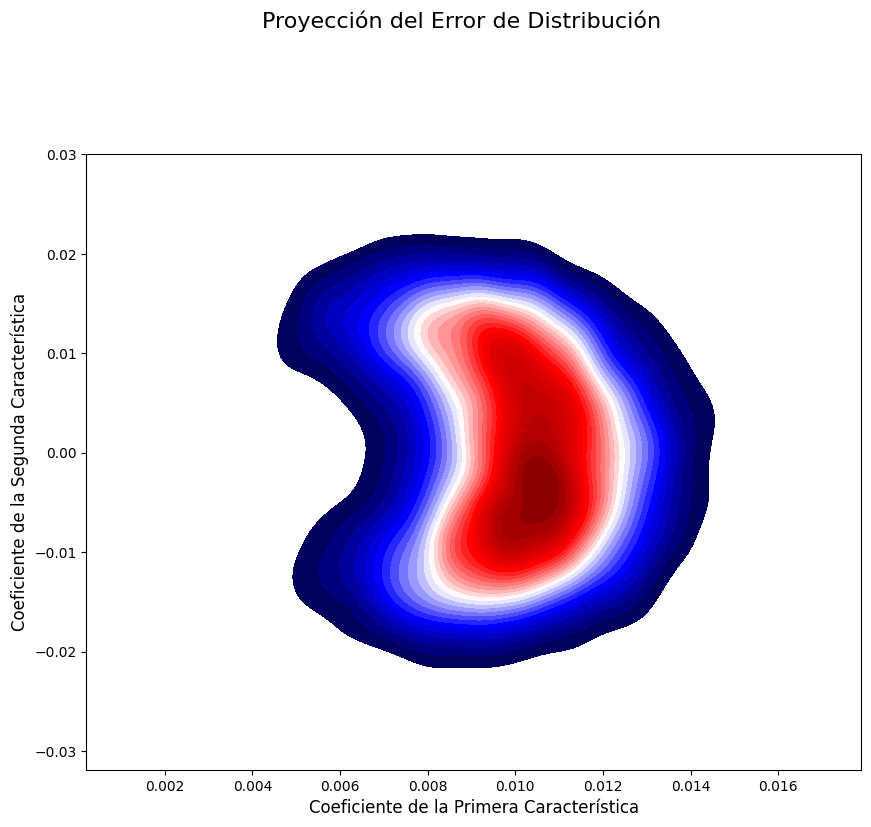

In [ ]:
# Se aplica SVD
U, S, Vt = np.linalg.svd(errors_squared, full_matrices=False)

# Se seleccionan las componentes a graficar
x_axis = U[:, 0]
y_axis = U[:, 1]

# Se grafica la figura
plt.figure(figsize=(10, 8))
sns.kdeplot(x=x_axis, y=y_axis, fill=True, kind="kde", space=0, color="midnightblue", n_levels=30, cmap="seismic")
plt.xlabel("Coeficiente de la Primera Característica", fontsize=12)
plt.ylabel("Coeficiente de la Segunda Característica", fontsize=12)
plt.suptitle("Proyección del Error de Distribución", fontsize=16, y=1.06)
plt.show()

In [ ]:
errors_squared = np.concatenate(errors_squared)
dw_value = durbin_watson(errors_squared)
print(f"Durbin-Watson: {dw_value}")

if dw_value < 1.5:
    print("Los errores poseen una correlación positiva")
elif 1.5 <= dw_value <= 2.5:
    print("Los errores no presentan una correlación definida")
else:
    print("Los errores poseen una correlación negativa")

Durbin-Watson: 1.5922183195332122
Los errores no presentan una correlación definida


In [ ]:
# Se calcula el error absoluto medio (MAE) para el modelo corregido
mae = np.mean(np.abs(errors))

# Se estima el valor sigma (desviación estándar de los errores) usando la corrección de Bessel
sigma = np.std(errors, ddof=1)

print(f"R²: {r2_scores}")
print(f"Error absoluto medio: {mae}")
print(f"Desviación estándar de los errores: {sigma}")

R²: 0.5496269341436958
Error absoluto medio: 1.5901811384098692
Desviación estándar de los errores: 2.222188333759117
